In [1]:
import numpy as np

import functools as ft

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import progressbar

#kass.models.set_tf_seed(42)
random_state = np.random.RandomState(seed=42)

In [2]:
# get data
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
#x_train, y_train, x_test, y_test = [arr.astype("float32") for arr in [x_train, y_train, x_test, y_test]]

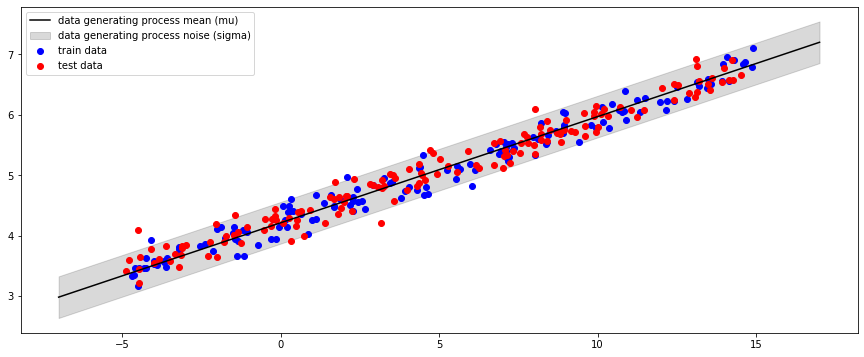

In [3]:
# make data


def fake_model(x):
    return 100.0 * x

num_samples = 150
scale_factor = 100

x_train = np.random.uniform(-10, 10, num_samples)
x_train = x_train.reshape(-1, 1)
y_train = fake_model(x_train) + random_state.normal(0, 100, num_samples).reshape(-1, 1) 

x_test = np.random.uniform(-10, 10, num_samples)
x_test = x_test.reshape(-1, 1)
y_test = fake_model(x_test) + random_state.normal(0, 100, num_samples).reshape(-1, 1)

feature_space = np.linspace(-12, 12, 1000).reshape(-1, 1)
y_true = fake_model(feature_space)

# scale data (best practice for good results)

y_train_mean = y_train.mean()
y_train_std = y_train.std()

scale = 1.0
y_train = scale * (y_train - y_train_mean) / y_train_std
y_test = scale * (y_test - y_train_mean) / y_train_std
y_true = scale * (y_true - y_train_mean) / y_train_std

x_train = x_train.astype("float32") + 5
y_train = y_train.astype("float32") + 5
x_test = x_test.astype("float32") + 5
y_test = y_test.astype("float32") + 5
feature_space = feature_space.astype("float32") + 5
y_true = y_true.astype("float32") + 5

# plot data

train_color = "b"
test_color = "r"

plt.figure(figsize=(15, 6))
plt.plot(feature_space[:, 0], y_true, c="k", label="data generating process mean (mu)")
plt.fill_between(feature_space[:, 0],
    y_true[:, 0] + 1.96 * scale * 100 / y_train_std, 
    y_true[:, 0] - 1.96 * scale * 100 / y_train_std,
    color="k", alpha=0.15, label="data generating process noise (sigma)"
)
plt.scatter(x_train[:, 0], y_train[:, 0], c=train_color, label="train data")
plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
plt.legend()
plt.show()

In [30]:
# set up functions

def define_layers(feature_dim, output_dim, hidden_layers=[]):
    
    layers = []
    # define input layer
    layers.append(feature_dim)
    # define hidden layers
    layers.extend(hidden_layers)
    # define output layer
    layers.append(output_dim*2)

    return layers

def get_random_initial_state(weight_prior, bias_prior, layers, overdisp=1.0):
    """Generate random initial configuration for weights and biases of a fully-connected NN
    sampled according to the specified prior distributions. This configuration can serve
    as a starting point for instance to generate a Markov chain of network configurations
    via Hamiltonian Monte Carlo which are distributed according to the posterior after having
    observed some data.
    """
    init_state = []
    for idx in range(len(layers) - 1):
        weights_shape = (layers[idx], layers[idx + 1])
        biases_shape = layers[idx + 1]
        # use overdispersion > 1 for better R-hat statistics
        weights = weight_prior.sample(tf.squeeze(weights_shape)) * overdisp
        biases = bias_prior.sample(tf.squeeze(biases_shape)) * overdisp
        init_state.extend((weights, biases))
    return init_state

# build network

def dense(inputs, weights, biases, activation):
    return activation(tf.matmul(inputs, weights) + biases)

def build_network(weights_list, biases_list, activation=tf.nn.relu):
    
    def model(samples, training=True):
        
        net = samples
        
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
            net = dense(net, weights, biases, activation)
            
        # final linear layer
        net = tf.matmul(net, weights_list[-1]) + biases_list[-1]
        
        # the model's predictive mean and log variance (each of size samples.shape(0))
        y_pred, y_std = tf.unstack(net, axis=1)
        y_std = 1e-3+tf.math.softplus(0.05*y_std)
        #y_std = 1.0
        
        if training:
            return tfp.distributions.Normal(loc=y_pred, scale=y_std)
        else:
            return y_pred, y_std

    return model

# inference functions

def tracer_factory(X, y):
    return lambda *args: ft.partial(bnn_log_prob_fn, X, y, get_mean=True)(
        args[::2], args[1::2]
    ).numpy()

# log_prior
def prior_log_prob_fn(weight_prior, bias_prior, weights, biases):
    log_prob = sum([tf.reduce_sum(weight_prior.log_prob(w)) for w in weights])
    log_prob += sum([tf.reduce_sum(bias_prior.log_prob(b)) for b in biases])
    return log_prob

# log_likelihood
def bnn_log_prob_fn(X, y, weights, biases, get_mean=False):
    """Compute log likelihood of predicted labels y given the
    features X, weights W and biases b.

    Args:
        X (np.array): 2d feature values.
        y (np.array): 1d labels (ground truth).
        weights (list): 2d arrays of weights for each layer.
        biases (list): 1d arrays of biases for each layer.
        get_mean (bool, optional): Whether to return the mean log
        probability over all labels for diagnostics, e.g. to
        compare train and test set performance. Defaults to False.

    Returns:
        tf.tensor: Sum or mean of log probabilities of all labels.
    """
    network = build_network(weights, biases)
    labels_dist = network(X)
    if get_mean:
        return tf.reduce_mean(labels_dist.log_prob(y))
    return tf.reduce_sum(labels_dist.log_prob(y))

# log_likelihood + log_prior
def target_log_prob_fn_factory(weight_prior, bias_prior, X_train, y_train):
    
    def target_log_prob_fn(*args):
        weights, biases = args[::2], args[1::2]
        log_prob = bnn_log_prob_fn(X_train, y_train, weights, biases)
        #log_prob += prior_log_prob_fn(weight_prior, bias_prior, weights, biases)
        return log_prob

    return target_log_prob_fn

# MAP

def get_map_trace(target_log_prob_fn, state, 
                  num_iters=1000,
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  save_every=10, 
                  callbacks=[]):
    
    state_vars = [tf.Variable(s) for s in state]
    
    def map_loss():
        return -target_log_prob_fn(*state_vars)

    @tf.function
    def minimize():
        optimizer.minimize(map_loss, state_vars)

    state_trace, cb_trace = [[] for _ in state], [[] for _ in callbacks]
    
    pbar = progressbar.ProgressBar()
    for i in pbar(range(num_iters)):
        if i % save_every == 0:
            for trace, state in zip(state_trace, state_vars):
                trace.append(state.numpy())
            for trace, cb in zip(cb_trace, callbacks):
                trace.append(cb(*state_vars))
        minimize()
        
    return state_trace, cb_trace

def get_best_map_state(map_trace, map_log_probs):
    test_set_max_log_prob_idx = np.argmax( np.asarray(map_log_probs[1]) + np.asarray(map_log_probs[0]) )
    return [tf.constant(tr[test_set_max_log_prob_idx]) for tr in map_trace]

100% |########################################################################|


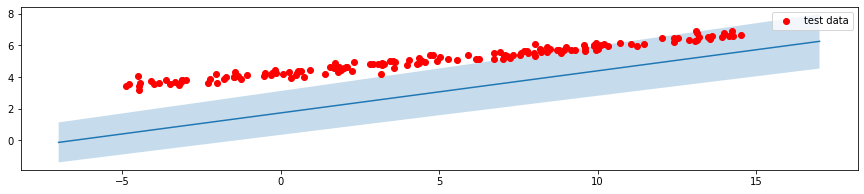

In [35]:
# define input and out dimensions
feature_dim = x_train.shape[1]
output_dim = 1

# define priors
weight_prior = tfp.distributions.Normal(0.0, 1.0)
bias_prior = tfp.distributions.Normal(0.0, 0.5)

# define network structure (# layers and # units)
layers = define_layers(feature_dim, output_dim, hidden_layers=[])

# initialize weights
random_initial_state = get_random_initial_state(
    weight_prior, bias_prior, 
    layers
)

for i in range(1):

    log_prob_tracers = (
        tracer_factory(x_train, y_train),
        tracer_factory(x_test, y_test),
    )

    trace, log_probs = get_map_trace(
        target_log_prob_fn_factory(weight_prior, 
                                   bias_prior, 
                                   x_train, 
                                   y_train),
        random_initial_state,
        optimizer=tf.optimizers.Adagrad(learning_rate=0.05),
        num_iters=100,
        callbacks=log_prob_tracers,
    )

    
    
    best_params = get_best_map_state(trace, log_probs)
    random_initial_state = best_params
    
    weights, biases = best_params[::2], best_params[1::2]
    model = build_network(weights, biases)
    y_pred, y_var = model(feature_space, training=False)
    
    plt.figure(figsize=(15, 3))
    plt.plot(feature_space[:, 0], y_pred)
    plt.fill_between(
        feature_space[:, 0], y_pred + 1.96*y_var, y_pred - 1.96*y_var, alpha=0.25 
    )


    plt.scatter(x_test[:, 0], y_test[:, 0], c=test_color, label="test data")
    plt.legend()
    plt.show()

In [36]:
np.asarray(log_probs[1]) + np.asarray(log_probs[0])

array([-28.188965, -22.642282, -20.95823 , -19.817238, -18.923615,
       -18.180334, -17.540825, -16.978203, -16.475252, -16.020147],
      dtype=float32)